In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
students = pd.read_csv("students.csv")

Przede wszystkim należy zauważyć, że według opisu podanego na [stronie z danymi](https://www.kaggle.com/uciml/student-alcohol-consumption) część studentów się powtarza. Powiedziane jest, że możemy ich znaleźć szukająć wierszy ze zduplikowanymi wartościami w atrybutach

    "school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"




In [18]:
identifying_attributes = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"]
students[identifying_attributes].duplicated().sum()

382

Sprawdźmy czy inne atrybuty rozróżniają potencjalne duplikaty. Należy jednak pamiętać, że atrybuty takie jak ```paid``` lub ```absences``` są zależne od przedmiotu dlatego będą się różniły nawet dla tej samej osoby. Pomijając te atrybuty (zależne od klasy) możemy wyodrębnić wszystkich powtarzających się studentów.

In [19]:
class_specific_attributes = ["G1", "G2", "G3", "paid", "activities", "absences", "failures", "class"]
students.drop(class_specific_attributes, axis=1).duplicated().sum()

372

In [63]:
data = students.loc[~students.drop(class_specific_attributes, axis=1).duplicated()].reset_index(drop=True)
len(data)

672

Przekśtałćmy niektóre kolumny (w szczególności binarne) na liczby

In [64]:
binary_attributes = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
one_code = ["GP", "F", "U", "GT3", "A", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes", "yes"]
for i in range(len(binary_attributes)):
    data[binary_attributes[i]] = 1*((data[binary_attributes[i]] == one_code[i]) | (data[binary_attributes[i]] == 1))
    # drugi warunek jest po to, aby przy drugim uruchomieniu komórki nie zerowały się wszystkie kolumny
data

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,class
0,1,1,18,1,1,1,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,1,1,17,1,1,0,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,1,1,15,1,0,0,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,1,1,15,1,1,0,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,1,1,16,1,1,0,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0,1,19,0,1,1,1,1,at_home,at_home,...,5,4,1,4,1,0,8,0,0,portuguese
668,0,1,18,0,1,0,2,2,services,other,...,2,1,1,1,4,5,14,14,15,portuguese
669,0,1,18,0,0,1,1,2,at_home,other,...,3,4,1,4,5,0,16,15,15,portuguese
670,0,1,19,0,1,0,1,1,at_home,other,...,3,3,1,1,3,4,7,8,9,portuguese


Teraz możemy przejść do faktycznej eksploracji danych

In [65]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      672 non-null    int32 
 1   sex         672 non-null    int32 
 2   age         672 non-null    int64 
 3   address     672 non-null    int32 
 4   famsize     672 non-null    int32 
 5   Pstatus     672 non-null    int32 
 6   Medu        672 non-null    int64 
 7   Fedu        672 non-null    int64 
 8   Mjob        672 non-null    object
 9   Fjob        672 non-null    object
 10  reason      672 non-null    object
 11  guardian    672 non-null    object
 12  traveltime  672 non-null    int64 
 13  studytime   672 non-null    int64 
 14  failures    672 non-null    int64 
 15  schoolsup   672 non-null    int32 
 16  famsup      672 non-null    int32 
 17  paid        672 non-null    int32 
 18  activities  672 non-null    int32 
 19  nursery     672 non-null    int32 
 20  higher    

<ipython-input-65-c1a516913eb1>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  data.info(verbose=True, null_counts=True)


Na razie nie będziemy kodować zmiennych kategorycznych bo nie budujemy jeszcze modelu a jedynie szukamy zależności dlatego zajmiemy się nimi osobno

In [66]:
categorical_attributes = []
for col in data.columns:
    if data[col].dtype == object:
        categorical_attributes.append(col)
categorical_attributes

['Mjob', 'Fjob', 'reason', 'guardian', 'class']

In [67]:
data.iloc[:,0:10].describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,0.656250,0.587798,16.812500,0.697917,0.700893,0.123512,2.495536,2.297619
std,0.475313,0.492598,1.264189,0.459503,0.458208,0.329269,1.132099,1.097671
min,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1.000000,1.000000,17.000000,1.000000,1.000000,0.000000,2.000000,2.000000
75%,1.000000,1.000000,18.000000,1.000000,1.000000,0.000000,4.000000,3.000000
max,1.000000,1.000000,22.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [68]:
data.iloc[:,10:20].describe()

,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,1.566964,1.928571,0.336310,0.104167,0.605655,0.290179,0.482143,0.796131
std,0.745565,0.824884,0.722219,0.305704,0.489074,0.454183,0.500053,0.403173
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,4.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
data.iloc[:,20:30].describe()

,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,0.891369,0.763393,0.375000,3.938988,3.188988,3.178571,1.501488,2.279762,3.534226,4.875000
std,0.311407,0.425316,0.484484,0.939685,1.057933,1.166198,0.921670,1.284671,1.435765,6.823897
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000
50%,1.000000,1.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000
75%,1.000000,1.000000,1.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,7.250000
max,1.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000


Nie widać żadnych braków danych (NA). Mogą być jakieś braki danych zakodowane przez twórców jednach w opisie zestawu nie ma nic takiego powiedziane.

<AxesSubplot:>

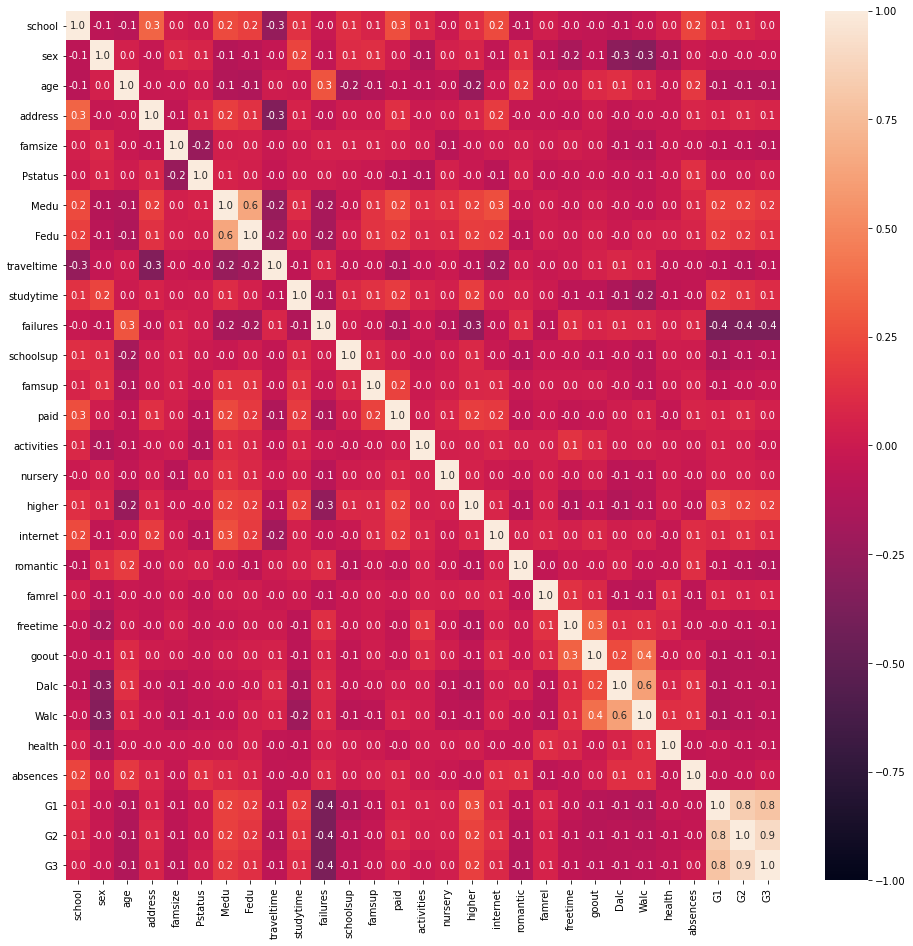

In [72]:
# UWAGA! +- 10 sekund wykonania (na moim komputerze)
plt.figure(figsize=(16,16))
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, fmt=".1f", vmin=-1, vmax=1)

Żeby nie zgubić się w tak dużej ilości danych ogarniczmy się tylko do ostatnich trzech wierszy (zmienne opisujace nie są ze sobą zbytnio skorelowane oprócz kilku wyjątków takich jak spożycie alkoholu)

<AxesSubplot:>

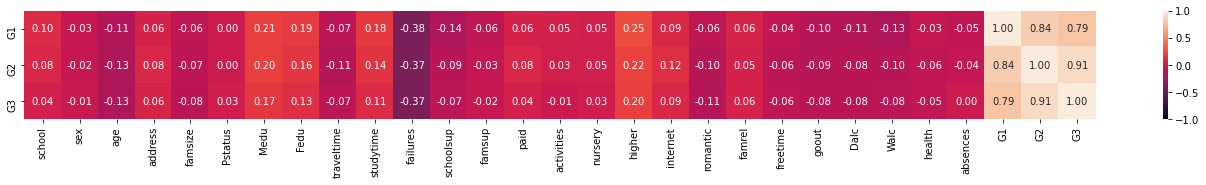

In [95]:
plt.figure(figsize=(24,2))
corr_limit = corr.iloc[26:]
sns.heatmap(corr_limit, vmin = -1, vmax = 1, annot=True, fmt=".2f")


Oceny oczywiście są ze sobą skorelowane. Podobnie można było się spodziewać odrowtnej korelacji z liczbą niezaliczeń (```failures```).
Ponad przeciętnym wyznacznikiem dobrej oceny jest także chęć kontynuacji edukacji na uczelni (atrybut ```higher```).
W końcu, pozostałymi czynnikami mającymi znaczenie jest edukacja rodziców (```F/Medu```). Co ciekaw edukacja matki jest tutaj dużo ważniejsza od edukacji ojca. Odnosząc się do tego ostatniego możemy sprawdzić jaki wpływ ma edukacja rodziców gdy są oni po rozwodzie (```Pstatus```).

In [98]:
data_Pstatus_A = data[data["Pstatus"] == 1]
data_Pstatus_T = data[data["Pstatus"] == 0]

In [105]:
data_Pstatus_A[["G1", "G2", "G3", "Medu", "Fedu"]].corr()

,G1,G2,G3,Medu,Fedu
G1,1.000000,0.891115,0.853633,0.117824,0.118829
G2,0.891115,1.000000,0.948270,0.103288,0.154835
G3,0.853633,0.948270,1.000000,0.078980,0.138083
Medu,0.117824,0.103288,0.078980,1.000000,0.503810
Fedu,0.118829,0.154835,0.138083,0.503810,1.000000


In [106]:
data_Pstatus_T[["G1", "G2", "G3", "Medu", "Fedu"]].corr()

,G1,G2,G3,Medu,Fedu
G1,1.000000,0.835431,0.786921,0.218919,0.196789
G2,0.835431,1.000000,0.906134,0.213580,0.157652
G3,0.786921,0.906134,1.000000,0.181168,0.126389
Medu,0.218919,0.213580,0.181168,1.000000,0.660266
Fedu,0.196789,0.157652,0.126389,0.660266,1.000000


W rodzinach, w których rodzicie się nie rozwiedli lepiej koreluje edukacja ojca z kolei w rodzinach, w których rozwód miał miejsce dużo lepszym wyznacznikem była edukacja matki. Być może jest to spowodowane tym, że po rozwodzie często opiekę nad dzieckiem sprawują matki i ich wyższa edukacja może być skorelowana z zarobkami, a więc z możliwością wsparcia dziecka. Podobnie w rodzinach bez rozwodu często (niestety) normą jest, że jeśli któryś z rodziców nie pracuje to jest to matka, zatem większą różnicę robi edukacja ojca.

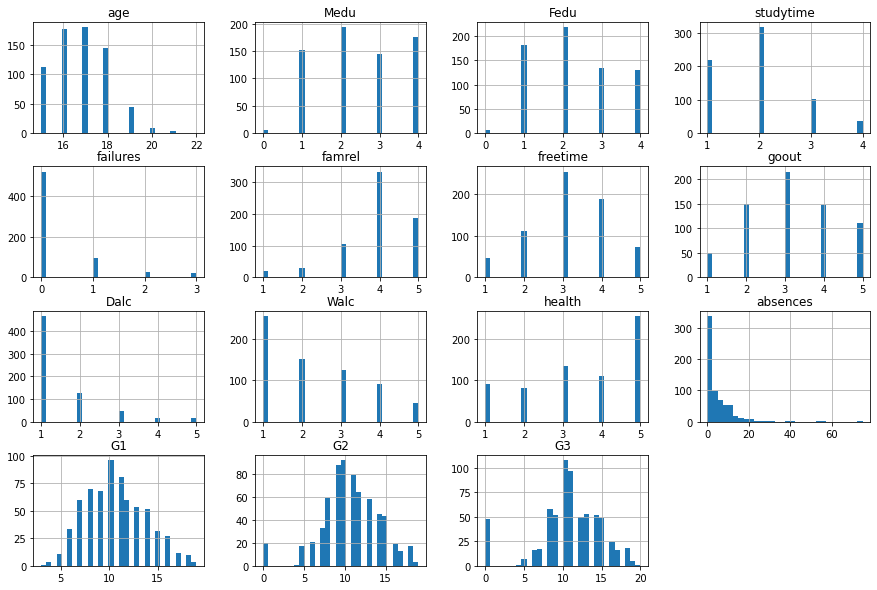

In [113]:
# zmienne niebinarne
cols_to_plot = ["age", "Medu", "Fedu", "studytime", "failures", "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3"]
data[cols_to_plot].hist(bins=30, figsize=(15, 10))
plt.show()

Widzimy, że większość zmiennych ma rozkład normalny lub skośny. W szczególności nie mamy doczynienia z rozkładami U-kształtnymi

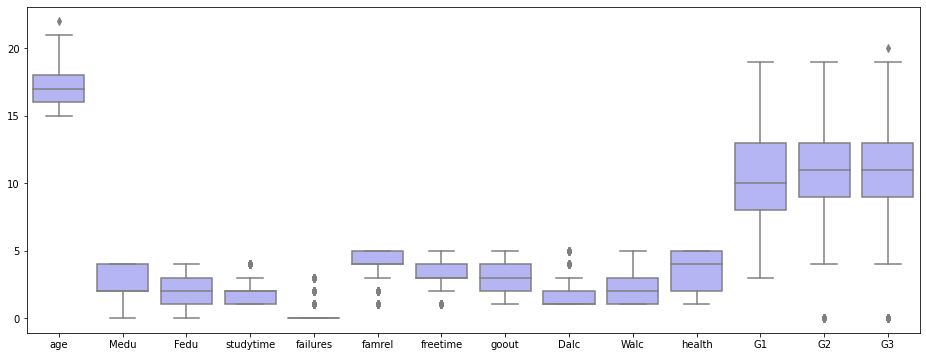

In [146]:
plt.figure(figsize=(16,6))

ax = sns.boxplot(data = data[cols_to_plot].drop("absences", axis=1), color = "#aaaaff")

<AxesSubplot:xlabel='failures', ylabel='Count'>

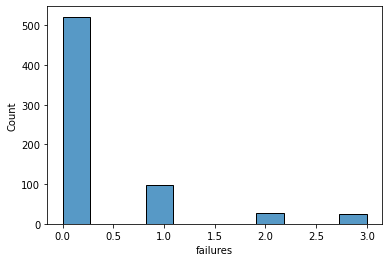

In [165]:
sns.histplot(data = data['failures'])

Widać, że liczba niezaliczeń jest relatywnie bardzo niewielka

<AxesSubplot:xlabel='absences', ylabel='Count'>

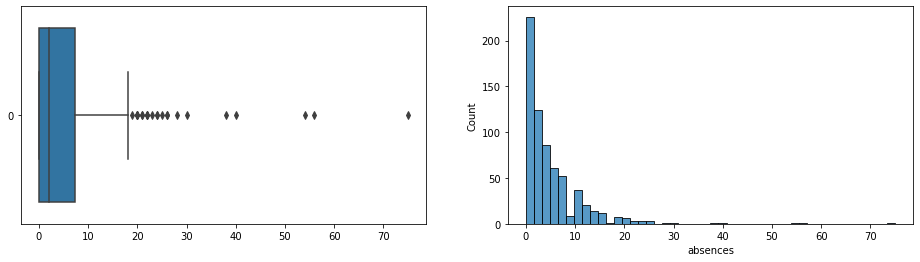

In [173]:
fig, axes = plt.subplots(1, 2,figsize=(16,4))
sns.boxplot(data = data['absences'], ax=axes[0], orient='h')
sns.histplot(data = data['absences'], ax=axes[1])

Z kolei nieobecności mają rozkład wykładniczy i zdecydowana większość uczniów nie przyszła na niewięcej niż 10 zajęć (lub w nie więcej niż 10 dni)

Sprawdźmy korelacje między atrybutami ```Dalc```, ```Walc``` i ```goout```. Nie możemy do tego wykorzystać zwykłego scatterplota, poniważ wartości dysrketne nakładają się na siebie i nie widać dokładnie trendów. Korzystając z jitterplota czy heatmapy możemy to lepiej zobrazować.

<AxesSubplot:xlabel='Walc', ylabel='Dalc'>

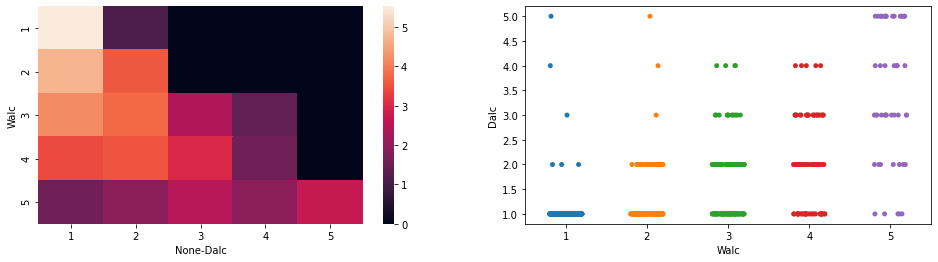

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

tmp = data[['Walc', 'Dalc']].groupby(['Walc', 'Dalc'])['Walc'].agg(n = lambda x : np.log(len(x))).unstack().fillna(0)
sns.heatmap(tmp, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5], ax=axes[0])
sns.stripplot(data=data, x = "Walc", y = "Dalc", ax = axes[1], jitter=0.2)

<AxesSubplot:xlabel='Walc', ylabel='Dalc'>

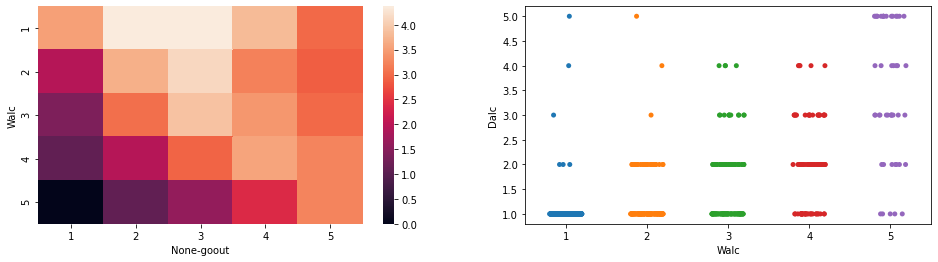

In [218]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

tmp = data[['Walc', 'goout']].groupby(['Walc', 'goout'])['Walc'].agg(n = lambda x : np.log(len(x))).unstack().fillna(0)
sns.heatmap(tmp, xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5], ax= axes[0])
sns.stripplot(data=data, x = "Walc", y = "Dalc", ax = axes[1], jitter=0.2)

Faktycznie widać korelacją odwrotną między ```Walc``` a pozostałymi atrybutami. Być może warto zastanowić się nad usunięciem niektórych atrybutów o wysokiej korelacji z innymi.

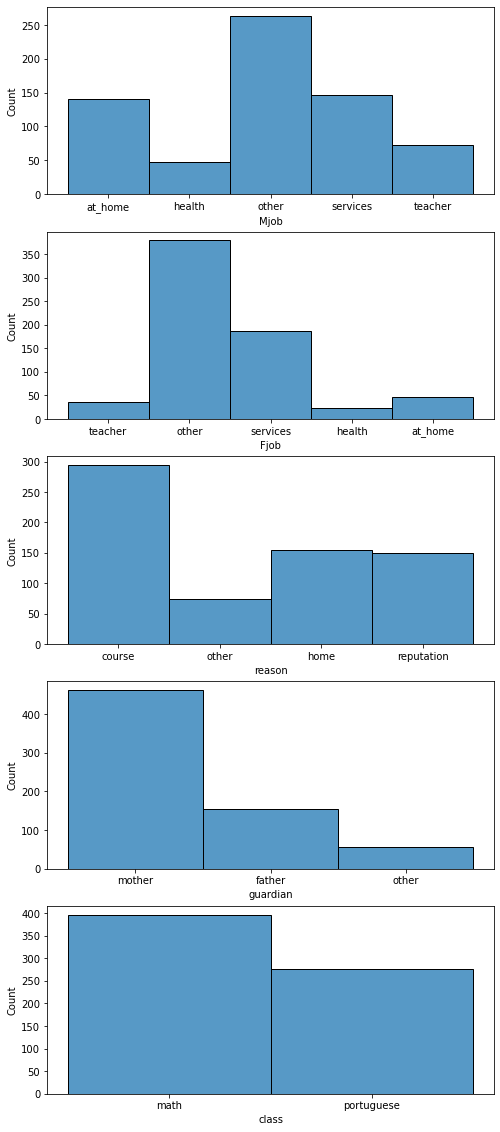

In [231]:
fig, axes = plt.subplots(len(categorical_attributes), 1, figsize=(8, 20))

for i, col in enumerate(categorical_attributes):
    sns.histplot(data = data, x = col, ax=axes[i])

Dla typu pracy najczęstszą (z dużą przewagą) jest kategoria ```other```. Być może po zakodowaniu te atrybuty nie będą aż tak dobrze korelować z ocenami.

In [233]:
data[categorical_attributes].isna().sum(axis=0)

Mjob        0
Fjob        0
reason      0
guardian    0
class       0
dtype: int64

Brak braków danych dla zmiennych kategorycznych (ponownie, w opisie danych nie ma mowy o kodowaniu braku danych)